# Определение возраста покупателей

# Введение

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
<li>Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;</li>
<li>Контролировать добросовестность кассиров при продаже алкоголя.</li>

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Для построения модели имеется набор фотографий людей с указанием возраста.

**План выполнения проекта:**
1. Проведение исследовательского анализ набора фотографий.
2. Подготовка данных к обучению.
3. Обучение нейронной сети и оценка её качества.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
sns.set()

Выполним загрузку данных и проверим размер выборки:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Вывод**

Датасет labels состоит из 2 столбцов (признаков) и 7591 строк (объектов). Пропущенные значения в датасете отсутствуют.

Целевой признак "real_age", содержащий сведения о реальном возрасте, имеет целочисленный тип данных.

В проекте требуется решить задачу регрессии.

Построим график распределения возраста в выборке:

Text(0.5, 0, 'Возраст, лет')

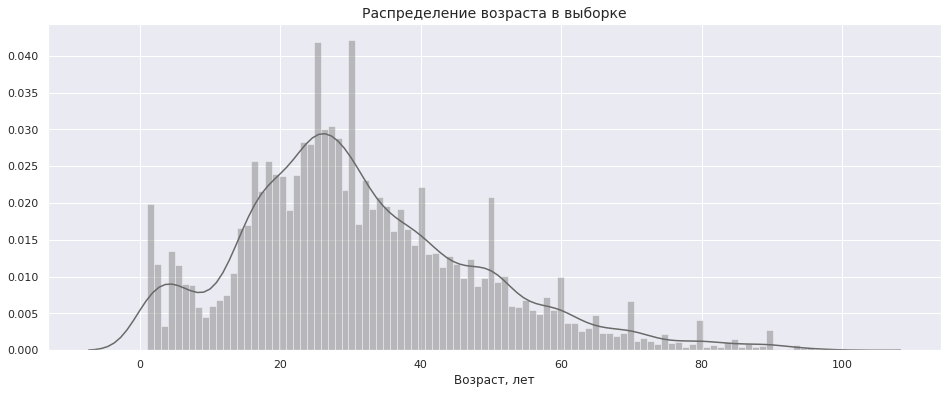

In [6]:
plt.figure(figsize=(16,6))
sns.distplot(labels['real_age'], color='dimgrey', bins=100)
plt.title('Распределение возраста в выборке', size=14)
plt.xlabel('Возраст, лет')

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Датасет содержит информацию о фотографиях людей, возрастом от 1 года до 100 лет.
Основная часть людей на изображениях в возрасте 20-40 лет, большое количество годовалых детей. Медианное значение - 29 лет.

Создадим загрузчик ImageDataGenerator и напечатаем фотографии на экране:

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        seed=17)

Found 7591 validated image filenames.


In [9]:
features, target = next(train_gen_flow)

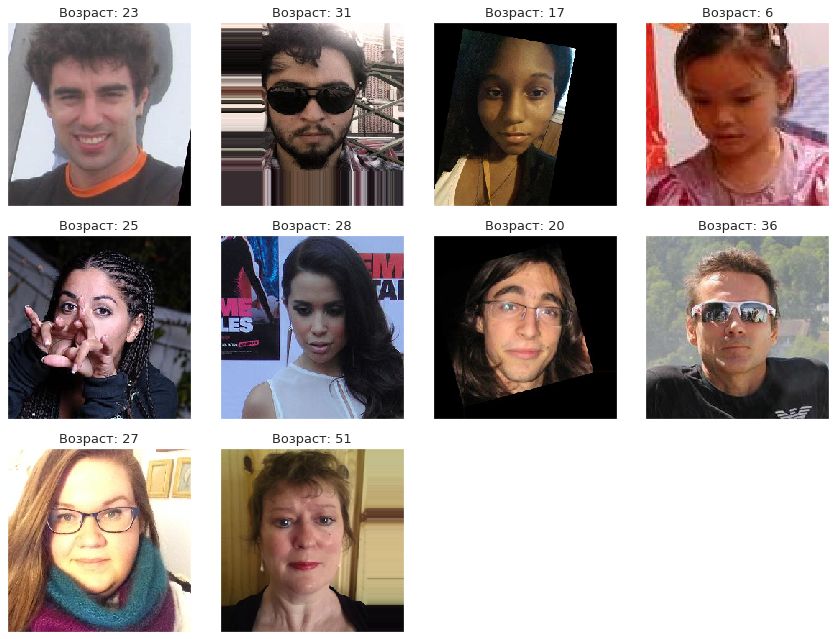

In [10]:
fig = plt.figure(figsize=(12,12))
for i in range(10):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.title('Возраст: {}'.format(target[i]), size=13)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод по разделу 1

1. Датасет labels состоит из 2 столбцов (признаков) и 7591 строк (объектов). Пропущенные значения в датасете отсутствуют.
Целевой признак "real_age", содержащий сведения о реальном возрасте, имеет целочисленный тип данных.

2. Датасет содержит информацию о фотографиях людей, возрастом от 1 года до 100 лет.
Основная часть людей на изображениях в возрасте 20-40 лет, большое количество годовалых детей. Медианное значение - 29 лет.

3. Вероятно, модель будет хорошо обучаться для людей в возрасте 20-40 лет, воозможно переобучение модели для пиковых значений графика распределения. Для остальных возрастов модель может обучаться не так хорошо, особенно для людей в возрасте после 60 лет, где информации не так много.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# Выполним загрузку необходимых библиотек:

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

# Напишем функции load_train(path) и load_test(path) 
# для загрузки обучающей и тестовой подвыборок

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

# Создадим модель с применением архитектуры ResNet50,
# одним нейроном и активацией ReLU

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

# Напишем функцию обучения модели

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

**Результат вывода на экран:**

```
# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 356 steps, validate for 119 steps
Epoch 1/10
2021-09-13 17:04:09.537961: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-13 17:04:09.909855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 105s - loss: 196.6157 - mae: 10.2292 - val_loss: 543.7773 - val_mae: 18.0168
Epoch 2/10
356/356 - 39s - loss: 80.2898 - mae: 6.8321 - val_loss: 147.8000 - val_mae: 9.5859
Epoch 3/10
356/356 - 39s - loss: 55.8989 - mae: 5.7269 - val_loss: 79.2586 - val_mae: 6.6081
Epoch 4/10
356/356 - 39s - loss: 46.1117 - mae: 5.1792 - val_loss: 77.5012 - val_mae: 6.6224
Epoch 5/10
356/356 - 39s - loss: 32.8106 - mae: 4.3889 - val_loss: 93.4734 - val_mae: 7.3024
Epoch 6/10
356/356 - 39s - loss: 25.1547 - mae: 3.7983 - val_loss: 69.6007 - val_mae: 6.2806
Epoch 7/10
356/356 - 39s - loss: 19.2346 - mae: 3.3411 - val_loss: 66.1737 - val_mae: 6.0175
Epoch 8/10
356/356 - 40s - loss: 15.1404 - mae: 2.9890 - val_loss: 65.5376 - val_mae: 5.9765
Epoch 9/10
356/356 - 40s - loss: 15.0798 - mae: 2.9431 - val_loss: 66.2173 - val_mae: 6.0014
Epoch 10/10
356/356 - 39s - loss: 13.4561 - mae: 2.8229 - val_loss: 63.8056 - val_mae: 6.0869
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 63.8056 - mae: 6.0869
Test MAE: 6.0869

```

### Вывод по разделу 2

На втором этапе работы в отдельном GPU-тренажёре обучена модель и получены результаты. Создана свёрточная нейронная сеть с применением архитектуры ResNet50, оптимизатором Adam (learning rate = 0.0001), одним нейроном и функцией активации ReLU. В качестве контрольной метрики применено МАЕ.

Получено значение MAE на `тренировочной выборке` **2.8229**; MAE на `валидационной выборке` **6.0869**, что удовлетворяет условиям поставленной задачи.

## Анализ обученной модели

На валидационной выборке нейронная сеть ошибается в среднем на 6 лет при прогнозе возраста по фото. Обучение 1 эпохи происходит в течение 39-40 секунд.

Полученный результат удовлетворяет условиям поставленной задачи и поможет определять возраст клиентов, чтобы предлагать товары, которые могут заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя.

## Общий вывод

В данной проектной работе для внедрения системы компьютерного зрения в сетевом супермаркете «Хлеб-Соль» на основании имеющегося набора фотографий людей с указанием возраста построена модель нейронной сети для определения приблизительного возраста человека. Выполнены следующие этапы:

1. Выполнена загрузка данных, проведен исследовательский анализ. Определено, что датасет содержит информацию о фотографиях людей, возрастом от 1 года до 100 лет. Основная часть людей на изображениях в возрасте 20-40 лет, большое количество годовалых детей. Медианное значение - 29 лет. Вероятно, модель будет хорошо обучаться для людей в возрасте 20-40 лет, воозможно переобучение модели для пиковых значений графика распределения. Для остальных возрастов модель может обучаться не так хорошо, особенно для людей в возрасте после 60 лет, где информации не так много.

2. На втором этапе работы в отдельном GPU-тренажёре обучена модель и получены результаты. Создана свёрточная нейронная сеть с применением архитектуры ResNet50, оптимизатором Adam (learning rate = 0.0001), одним нейроном и функцией активации ReLU. В качестве контрольной метрики применено МАЕ.
Получено значение MAE на тренировочной выборке 2.8229; MAE на валидационной выборке 6.0869, что удовлетворяет условиям поставленной задачи.

3. Выполнен краткий анализ обученной модели. На валидационной выборке нейронная сеть ошибается в среднем на 6 лет при прогнозе возраста по фото. Обучение 1 эпохи происходит в течение 39-40 секунд. Полученный результат удовлетворяет условиям поставленной задачи и поможет определять возраст клиентов, чтобы предлагать товары, которые могут заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя.